In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random
from collections import Counter 
import statistics
import time
from random import randint

In [2]:
dataset = pd.read_csv('C://Users//Eloisa//Desktop//UNI LORENZO//ADM//Homework 5//wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [3]:
dataset.columns=['Index','Source','Target']

In [4]:
# check if index columns has unique values
print(len(dataset.Index))
print(len(set(dataset.Index)))

483094
483094


In [5]:
dataset.set_index('Index' , inplace = True)
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222



#### Associate single category to each node

In [6]:
# all nodes in and out
unique_nodes = set(set(dataset.Source).union(set(dataset.Target)))
n_nodes = len(unique_nodes)
n_edges = len(dataset)

In [7]:
category_file = 'C://Users//Eloisa//Desktop//UNI LORENZO//ADM//Homework 5//wiki-topcats-categories.txt'

In [8]:
categories = {v: [] for v in unique_nodes}
categories_to_nodes = {} # mantiene la struttura originale del file catgoria -> nodi
lost = []

with open(category_file) as file:
    for i in range(17364):
        line = file.readline()
        category = line.split(';')[0].split(':')[-1]
        nodes = line.split(';')[1].split(' ')[1:-2]
        existing_nodes = []
        
        for node in nodes:
            try:
                categories[int(node)].append(category)
            except:
                lost.append(int(node))
            
            if int(node) in unique_nodes:
                existing_nodes.append(node)
        
        if existing_nodes != []:    
            categories_to_nodes[category] = existing_nodes

In [9]:
categories_filtered = {}
for n in categories.keys():
    try:
        rand_category = random.choice(categories[n])
        categories_filtered[n] = rand_category
    except:
        categories_filtered[n] = None

#### Create graph

In [10]:
in_links = {v: [] for v in set(dataset.Source)}
out_links = {v: [] for v in set(dataset.Target)}

for row in dataset.iterrows():
    source = row[1][0]
    target = row[1][1]
    in_links[source].append(target)
    out_links[target].append(source)

In [11]:
# undirected version of the graph
links = in_links.copy()
links.update(out_links)

In [12]:
n_art_outlink = len(out_links)
n_art_inlink = len(in_links)

#### Check if directed

In [13]:
directed = False
for node in in_links:
    if len(set(in_links[node]).intersection(set(out_links[node]))) != 0:
        directed = True
        break
if directed:
    print('Graph is directed')
else:
    print('Graph is undirected')

Graph is directed


#### Density

In [14]:
density = (n_edges/(n_nodes*(n_nodes-1)))
avarage = n_edges/n_nodes

print('Graph density is:',density)
print('Graph hyperliks avarage is:',avarage)

Graph density is: 4.9951571365597335e-05
Graph hyperliks avarage is: 4.912337431235573



#### Visualize the nodes' degree distribution


In [15]:
my_len = [] 
for node in links.keys():
    my_len.append(len(links[node]))

# dictionary with degree
node_degree = dict(zip(links.keys(), my_len))
d = Counter(node_degree)

In [16]:
# degree distribution
counter_supp = list()
for i in range(1, max(my_len)):
    counter_supp.append(my_len.count(i))

In [17]:
# cumulative degree ditribution
counter = [0]
for i in range(1, max(my_len)):
    counter.append(counter[-1]+my_len.count(i))

In [18]:
len(counter)

10815

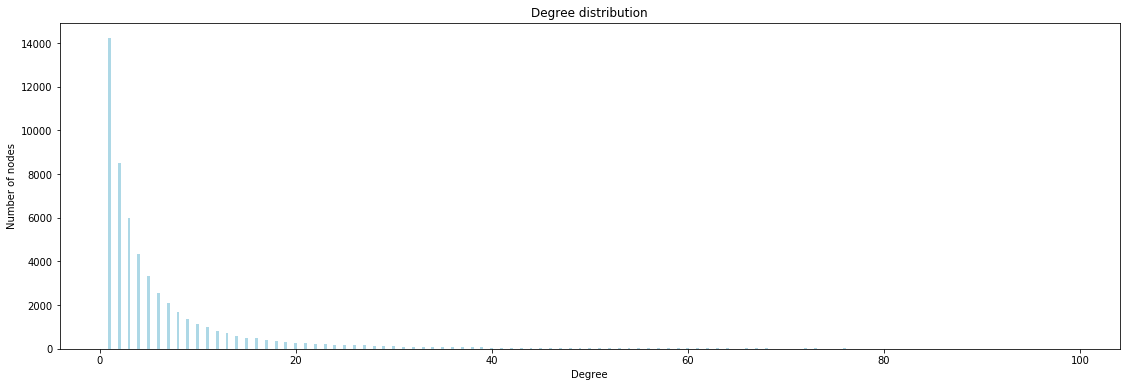

In [19]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter_supp[1:100])+1)),height = counter_supp[1:100],color = 'lightblue',width = 0.3);
#plt.plot(counter[1:100],color = 'lightblue');
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Degree distribution')
plt.show()

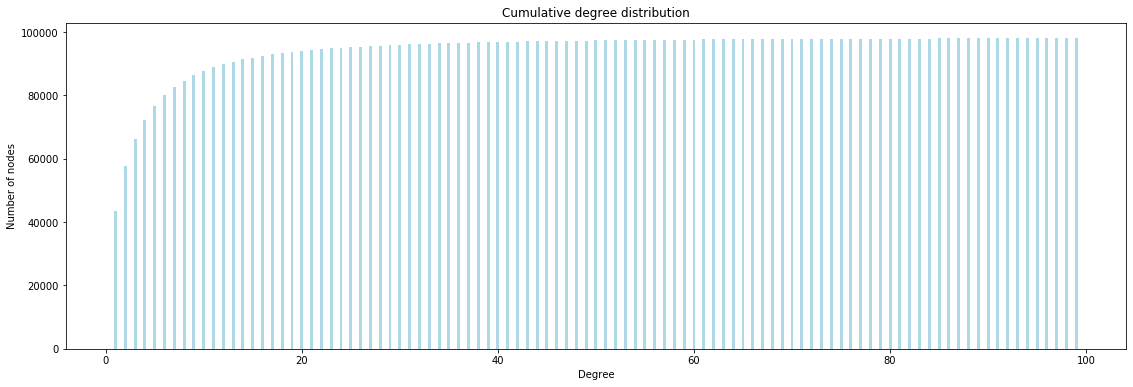

In [20]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter[1:100])+1)),height = counter[1:100],color = 'lightblue',width = 0.3);
#plt.plot(counter[1:100],color = 'lightblue');
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Cumulative degree distribution')
plt.show()

### Useful functions

In [21]:
def shortest_path (node1,node2):
    
    ''' This function takes in input two nodes and returns the length of the shortest path.
    If node 1 does not have any outlink or if no path is found between node 1 and node 2, None is returned. '''
    
    # exeptions
    if node1 == node2:
        return 0
    
    # set of outnodes of node 1
    try:
        out_nodes = set(out_links[node1]) 
    except:
        print('No out-link from', node1)
        return None
    
    # initializing explored nodes set and minimu distance
    explored = set() 
    clicks = 1
    
    # 1. we iterate until we don't find node 2 
    # 2. we check the new set of out-nodes to explore is non-empty 
    # 3. we iterate through unexplored nodes
    # 4. if the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes
    while node2 not in out_nodes: 
        
        if out_nodes != set(): 
            new_out_nodes = set() 

            for node in out_nodes:  
                try:
                    new_out_nodes = new_out_nodes.union(set(out_links[node]))
                except:
                    continue
            
            # update
            explored = explored.union(out_nodes)
            out_nodes = new_out_nodes.difference(explored) 
            clicks += 1 
        
        # case in which we have not found node 2 but we don't have any other node to explore
        else: 
            #print('No path found')
            return None
    
    return clicks

In [22]:
def explore(node,limit):
   
    ''' This function takes as an input one node and a click limit.
    Limit can be set to None if we don't want any limit.
    The function returns a dictionary where keys are distances and values are all the nodes 
    which are at distance d (key) from the input node'''
    
    # initializing variables
    distance_tree = {}
    explored = set()
    clicks = 1 
    
    # checking if node has at list one outlink
    try:
        out_nodes = set(out_links[node]) # set of outnodes of node 1
    except:
        print('No out-link from', node)
        return distance_tree
    
    # 1. We iterate until the new set of out-nodes to explore is non-empty 
    # 2. For each iteration we only consider unexplored nodes
    # 3. If the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes
    # 4. We update all variables and increase distance by one
    while out_nodes != set(): 
        
        # We return when limit is given and reached
        if limit != None:
            if clicks > limit+1:
                return distance_tree
        
        distance_tree[clicks] = out_nodes
        new_out_nodes = set() 
        
        for node in out_nodes: 
            
            try:
                new_out_nodes = new_out_nodes.union(set(out_links[node])) 
            except:
                continue
        
        explored = explored.union(out_nodes) 
        out_nodes = new_out_nodes.difference(explored)
        clicks += 1 
    
    return distance_tree

## RQ3

First of all we build a dictionary with the in-degree centrality of all the nodes in the filtered dictionary of nodes.

In [23]:
in_d = [] 
for node in in_links.keys():
    in_d.append(len(in_links[node]))

# dictionary with in-degree
in_degree = dict(zip(in_links.keys(), in_d))
in_degree

{786432: 3,
 786433: 1,
 786434: 1,
 786435: 2,
 786436: 4,
 786437: 1,
 786438: 12,
 786439: 1,
 786440: 1,
 786441: 1,
 786442: 1,
 786443: 1,
 786444: 1,
 786445: 2,
 786446: 1,
 786447: 1,
 786448: 6,
 786449: 1,
 786450: 4,
 786451: 1,
 786452: 1,
 786453: 1,
 786454: 2,
 786455: 1,
 786456: 1,
 786457: 2,
 786458: 1,
 786459: 1,
 786460: 1,
 786461: 1,
 786462: 1,
 786463: 1,
 786464: 4,
 786465: 1,
 786466: 1,
 786467: 2,
 786468: 1,
 786469: 1,
 786470: 6,
 786471: 1,
 786472: 1,
 786473: 16,
 786474: 135,
 786475: 1,
 786476: 3,
 786477: 1,
 786478: 1,
 786479: 1,
 786480: 2,
 786481: 1,
 786482: 1,
 786483: 1,
 786484: 1,
 786485: 1,
 786486: 1,
 786487: 1,
 786488: 1,
 786489: 1,
 786490: 1,
 786491: 1,
 786492: 1,
 786493: 1,
 786494: 1,
 786495: 1,
 786496: 1,
 786497: 2,
 786498: 2,
 786499: 2,
 786500: 1,
 786501: 1,
 786502: 1,
 786503: 5,
 786504: 1,
 786505: 3,
 786506: 1,
 786507: 1,
 786508: 1,
 786509: 1,
 786510: 1,
 786511: 1,
 786512: 1,
 786513: 33,
 786514: 1,

We build also an out-degree dictionary that we will use to make an assumption to calculate the shortest path.

In [24]:
out_d = [] 
for node in out_links.keys():
    out_d.append(len(out_links[node]))

# dictionary with out-degree
out_degree = dict(zip(out_links.keys(), out_d))
out_degree

{786432: 3,
 786433: 1,
 786434: 1,
 786435: 2,
 786436: 4,
 786437: 1,
 786438: 12,
 786439: 1,
 786440: 1,
 786441: 1,
 786442: 1,
 786443: 1,
 786444: 1,
 786445: 2,
 786446: 1,
 786447: 1,
 786448: 6,
 786449: 1,
 786450: 4,
 786451: 1,
 786452: 1,
 786453: 1,
 786454: 2,
 786455: 1,
 786456: 1,
 786457: 2,
 786458: 1,
 786459: 1,
 786460: 1,
 786461: 1,
 786462: 1,
 786463: 1,
 786464: 4,
 786465: 1,
 786466: 1,
 786467: 2,
 786468: 1,
 786469: 1,
 786470: 7,
 786471: 1,
 786472: 1,
 786473: 16,
 786474: 140,
 786475: 1,
 786476: 3,
 786477: 1,
 786478: 1,
 786479: 1,
 786480: 2,
 786481: 1,
 786482: 1,
 786483: 1,
 786484: 1,
 786485: 1,
 786486: 1,
 786487: 1,
 786488: 1,
 786489: 1,
 786490: 1,
 786491: 1,
 786492: 1,
 1048637: 6,
 1048638: 9,
 786493: 1,
 786495: 1,
 786496: 1,
 786498: 2,
 786497: 1,
 786500: 1,
 786501: 1,
 786499: 2,
 786503: 5,
 1048648: 3,
 786502: 1,
 786504: 1,
 786507: 1,
 786506: 1,
 1048653: 3,
 786505: 3,
 786508: 1,
 786509: 1,
 786513: 34,
 786510

In [25]:
list(out_degree.keys())

[786432,
 786433,
 786434,
 786435,
 786436,
 786437,
 786438,
 786439,
 786440,
 786441,
 786442,
 786443,
 786444,
 786445,
 786446,
 786447,
 786448,
 786449,
 786450,
 786451,
 786452,
 786453,
 786454,
 786455,
 786456,
 786457,
 786458,
 786459,
 786460,
 786461,
 786462,
 786463,
 786464,
 786465,
 786466,
 786467,
 786468,
 786469,
 786470,
 786471,
 786472,
 786473,
 786474,
 786475,
 786476,
 786477,
 786478,
 786479,
 786480,
 786481,
 786482,
 786483,
 786484,
 786485,
 786486,
 786487,
 786488,
 786489,
 786490,
 786491,
 786492,
 1048637,
 1048638,
 786493,
 786495,
 786496,
 786498,
 786497,
 786500,
 786501,
 786499,
 786503,
 1048648,
 786502,
 786504,
 786507,
 786506,
 1048653,
 786505,
 786508,
 786509,
 786513,
 786510,
 786511,
 786512,
 1179733,
 786517,
 786514,
 786515,
 786516,
 786518,
 655451,
 786519,
 655453,
 1048670,
 786527,
 786528,
 786529,
 1048674,
 786530,
 786532,
 786533,
 786534,
 786535,
 786536,
 786537,
 786538,
 786539,
 786540,
 786541,
 78

In [26]:
categories_filtered

{1048576: 'Alumni_of_University_College,_Oxford',
 1048577: 'Fellows_of_University_College,_Oxford',
 1048578: 'Year_of_birth_missing',
 1048579: 'Fellows_of_University_College,_Oxford',
 786432: 'Rivers_of_Hunedoara_County',
 786433: 'Rivers_of_Hunedoara_County',
 1048582: 'Fellows_of_University_College,_Oxford',
 1048583: 'English_Anglican_priests',
 1048584: 'Year_of_birth_missing',
 1048585: 'Fellows_of_University_College,_Oxford',
 1048586: 'English_Anglican_priests',
 1048587: 'Year_of_death_missing',
 1048588: 'Fellows_of_University_College,_Oxford',
 1048589: 'Year_of_birth_missing',
 786437: 'Rivers_of_Romania',
 786438: 'Rivers_of_Romania',
 786439: 'Rivers_of_Romania',
 786440: 'Rivers_of_the_Siret_subbasin',
 786441: 'Rivers_of_the_Siret_subbasin',
 786442: 'Rivers_of_Neam_County',
 786443: 'Rivers_of_Neam_County',
 786444: 'Rivers_of_Romania',
 786445: 'Rivers_of_Suceava_County',
 786446: 'Rivers_of_Romania',
 786447: 'Rivers_of_Romania',
 786448: 'Rivers_of_Romania',
 786

In [27]:
'''This function returns a subset of a list excluding the empty one.
   We use this function to get a set of poages from the requeted category'''
 

def set_of_pages(l):
    l_index = randint(0, len(l) - 1)
    r_index = randint(l_index + 1, len(l))
    return l[l_index:r_index]

We build the following function doing one assumption: since the problem's complexity is high, we have decided, after selecting the most central article, to determine the out-degree of the remaining nodes in the category.\
At this point we calculate the shortest path from the most central node to the node with the highest out-degree and then we select that node as the starting node for the next iteration.

In [29]:
def same_category_distance(C, p):
    # Calculating the most central article and removing it from the set of pages selected
    print(p)
    diz = {}
    for elem in [k for k,x in categories_filtered.items() if x == C]:
        try:
            diz[int(elem)] = in_degree[int(elem)]
        except:
            KeyError
    v = max(diz, key = diz.get)
    print(v)
    if v in p:
        p.remove(v)
    print(p)
    # Building the out-degree dictionary and sorting it by the degree in descending order
    diz_out = {}
    for elem in p:
            if elem in list(out_degree.keys()):
                diz_out[int(elem)] = out_degree[int(elem)]
            else: 
                diz_out[int(elem)] = 0
        
    print(diz_out)
    l1 = list(diz_out.items())
    l1.sort(key=lambda x:x[1],reverse = True)
    diz_out = dict(l1)
    print(diz_out)
    
    # Initializing a list to have the order of the nodes for which we want to calculate the shortest path
    nfd = []
    nfd.append(v)
    for elem in diz_out.keys():
        nfd.append(elem)
    
    # Calculating the shortest path with a heuristic way: for the first iteration we calculate the shortest distance from the node v to the node with the highest out-degree. 
    # This node, for the second iteration, becomes the node from which we start calculating the shortest path and the arrive is determined by the following node in the list.
    tot_d = []
    for i in range(len(nfd)-1):
        tot_d.append(shortest_path(nfd[i],nfd[i+1]))
    if None in tot_d:
        return( "Not possible")
    else:
        k = sum(tot_d)
        return(k)
    
    

In [37]:
C1 = 'Alumni_of_University_College,_Oxford'
p1 = [k for k,x in categories_filtered.items() if x == C1]
p1f = set_of_pages(p1)
print(C1)
print(p1)
print(p1f)

Alumni_of_University_College,_Oxford
[1048576, 537530, 539307, 541723, 1048570, 72728, 669654]
[537530, 539307, 541723, 1048570, 72728]


Now we apply this function to 2 different categories: here there are the results.

In [38]:
same_category_distance(C1,p1f)

[537530, 539307, 541723, 1048570, 72728]
541723
[537530, 539307, 1048570, 72728]
{537530: 15, 539307: 1, 1048570: 1, 72728: 1}
{537530: 15, 539307: 1, 1048570: 1, 72728: 1}


'Not possible'

In [71]:
C2 = 'Disney_films'
p2 = [k for k,x in categories_filtered.items() if x == C2]
p2f = set_of_pages(p2)
print(C2)
print(p2)
print(p2f)

Disney_films
[1048863, 1048920, 1048961, 1055087, 1056145, 1057860, 1058180, 1058656, 1065733, 1066380, 1067043, 1067729, 1068182, 1068247, 583195, 1065070, 1065485, 939699, 940107, 940285, 940435, 680779, 1245903, 1245905, 503555, 515766, 1042457]
[1067043, 1067729, 1068182]


In [72]:
same_category_distance(C2,p2f)

[1067043, 1067729, 1068182]
1065733
[1067043, 1067729, 1068182]
{1067043: 4, 1067729: 5, 1068182: 3}
{1067729: 5, 1067043: 4, 1068182: 3}


13

In [66]:
C3 = 'French_films'
p3 = [k for k,x in categories_filtered.items() if x == C3]
p3f = set_of_pages(p3)
print(C3)
print(p3)
print(p3f)

French_films
[1048750, 1050872, 1051011, 1051012, 1051072, 1051228, 1051248, 1051272, 1051372, 1051854, 1051855, 1052029, 1052648, 1052831, 1056240, 1056318, 1056408, 1056587, 1057841, 1058385, 1058506, 1058913, 1063322, 1065399, 1069432, 1047575, 1600929, 568110, 840702, 900367, 76729, 601092, 1132618, 472688, 1062494, 899371, 899875, 1692578, 1437303, 1446501, 1712359, 340925, 675393, 1201051, 686318, 436007, 436453, 1748472, 708668, 190197, 1244548, 730067, 995827, 1028340, 1030669, 1041503]
[1028340, 1030669]


In [67]:
same_category_distance(C3,p3f)

[1028340, 1030669]
1063322
[1028340, 1030669]
{1028340: 1, 1030669: 1}
{1028340: 1, 1030669: 1}


'Not possible'